In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
import torch
import config

from utils import show_abundance, plot_endmembers
from HySpecLab.metrics import rmse, sad

/home/abian/Workspace/Anaconda/envs/CLHU/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dataset import Urban
dataset = Urban(config.Urban_PATH)

result_path = os.path.join(config.RESULTS_PATH, 'urban/matlab')

In [3]:
from scipy import io as sio

endmember_estimation = sio.loadmat(os.path.join(result_path, 'endmember_estimation.mat'))
vca_ee = torch.tensor(endmember_estimation['VCA'])
nfindr_ee = torch.tensor(endmember_estimation['NFINDR'])

sad_result = sad(vca_ee, dataset.endmembers())
vca_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth

sad_result = sad(nfindr_ee, dataset.endmembers())
nfindr_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth

vca_ee = vca_ee[vca_idx]
nfindr_ee = nfindr_ee[nfindr_idx]

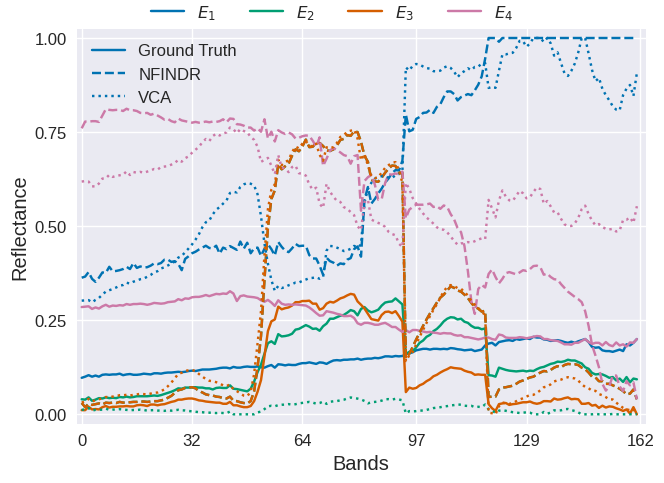

In [5]:
fig = plot_endmembers(dataset.endmembers(), ticks_range=(0, 1), 
                      endmember_estimation=[nfindr_ee, vca_ee],
                      ee_labels=['Ground Truth', 'NFINDR', 'VCA'])
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/endmembers_estimation.pdf'), bbox_inches='tight')

In [6]:
from HySpecLab.metrics import sad

sad_result_vca = sad(vca_ee, dataset.endmembers())
print(sad_result_vca, np.diagonal(sad_result_vca.numpy()).mean())
sad_vca = np.diagonal(sad_result_vca.numpy()).mean()

sad_result_nfindr = sad(nfindr_ee, dataset.endmembers())
print(sad_result_nfindr, np.diagonal(sad_result_nfindr.numpy()).mean())
sad_nfindr = np.diagonal(sad_result_nfindr.numpy()).mean()

tensor([[0.1921, 0.5741, 0.9863, 0.5368],
        [0.7570, 0.3917, 0.3200, 0.7063],
        [0.8530, 0.4376, 0.0557, 0.8056],
        [0.3259, 0.6068, 0.8522, 0.0944]]) 0.18350245
tensor([[0.1910, 0.5937, 0.9881, 0.5533],
        [0.8258, 0.4099, 0.0744, 0.8156],
        [0.8258, 0.4099, 0.0744, 0.8156],
        [0.5644, 0.6530, 0.7830, 0.2174]]) 0.22318015


In [7]:
FCLS = sio.loadmat(os.path.join(result_path, 'FCLS.mat'))
save_dir = os.path.join(result_path, 'imgs/LMM')

X_true = dataset.A @ dataset.endmembers()
# X_true = dataset.X


Xhat = FCLS['Xhat_NFINDR'].T

nfindr_reconstruct = torch.tensor(FCLS['Xhat_NFINDR'].T)
vca_reconstruct = torch.tensor(FCLS['Xhat_VCA'].T)
nfindr_A = torch.tensor(FCLS['A_NFINDR'].T)
vca_A = torch.tensor(FCLS['A_VCA'].T)
# dataframe which contains the RMSE
# Saving metrics
import pandas as pd
lmm_df = pd.DataFrame(columns=['Method', 'RMSE_X', 'RMSE_A', 'SAD_M'])
lmm_df['Method'] = ['LMM+NFINDR', 'LMM+VCA']
lmm_df['RMSE_X'] = [rmse(X_true, nfindr_reconstruct, dim=None).numpy(), rmse(X_true, vca_reconstruct, dim=None).numpy()]
lmm_df['RMSE_A'] = [rmse(dataset.A, nfindr_A, dim=None).numpy(), rmse(dataset.A, vca_A, dim=None).numpy()]
lmm_df['SAD_M'] = [sad_nfindr, sad_vca]
lmm_df

,Method,RMSE_X,RMSE_A,SAD_M
0,LMM+NFINDR,0.12520695,0.3332879052864812,0.223180
1,LMM+VCA,0.08434702,0.3308517982300189,0.183502


In [12]:
dataset.n_col
sio.loadmat(os.path.join(result_path, 'input.mat')).keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'n_endmembers', 'nRow', 'nCol', 'nBand'])

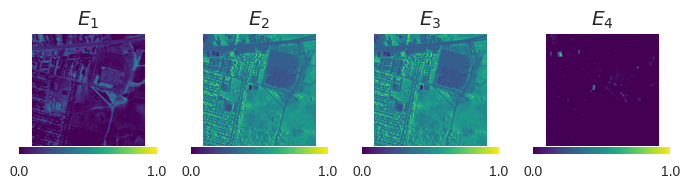

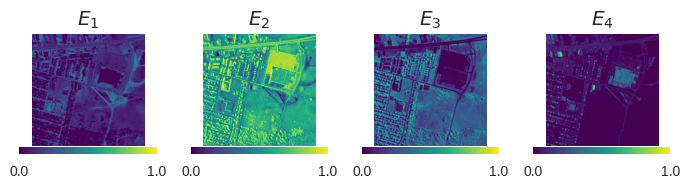

In [9]:
A = FCLS['A_NFINDR'].T.reshape(dataset.n_row,dataset.n_col,-1,order='C')
fig = show_abundance(A[:, :, nfindr_idx])
plt.show(fig)
fig.savefig(os.path.join(save_dir, 'A_NFINDR.png'), dpi=300, bbox_inches='tight')

A = FCLS['A_VCA'].T.reshape(dataset.n_row,dataset.n_col,-1,order='C')
fig = show_abundance(A[:, :, vca_idx])
plt.show(fig)
fig.savefig(os.path.join(save_dir, 'A_VCA.png'), dpi=300, bbox_inches='tight')

# ELMM

In [20]:
ELMM = sio.loadmat(os.path.join(result_path, 'ELMM.mat'))
save_dir = os.path.join(result_path, 'imgs/ELMM')

from HySpecLab.metrics import rmse
nfindr_reconstruct = torch.tensor(ELMM['Xhat_NFINDR'].T)
vca_reconstruct = torch.tensor(ELMM['Xhat_VCA'].T)
nfindr_A = torch.tensor(ELMM['A_NFINDR'].T)
vca_A = torch.tensor(ELMM['A_VCA'].T)

import pandas as pd
elmm_df = pd.DataFrame(columns=['Method', 'RMSE_X', 'RMSE_A', 'SAD_M'])
elmm_df['Method'] = ['ELMM+NFINDR', 'ELMM+VCA']
elmm_df['RMSE_X'] = [rmse(X_true, nfindr_reconstruct, dim=None).numpy(), rmse(X_true, vca_reconstruct, dim=None).numpy()]
elmm_df['RMSE_A'] = [rmse(dataset.A, nfindr_A, dim=None).numpy(), rmse(dataset.A, vca_A, dim=None).numpy()]
elmm_df['SAD_M'] = [sad_nfindr, sad_vca]

elmm_df

,Method,RMSE_X,RMSE_A,SAD_M
0,ELMM+NFINDR,0.3825547407433723,0.3171341295662535,0.070236
1,ELMM+VCA,0.382539236162474,0.3240091356102036,0.072431


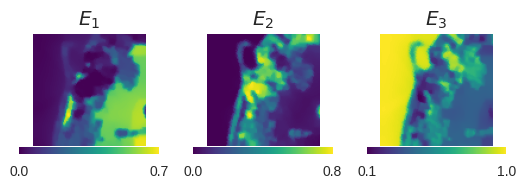

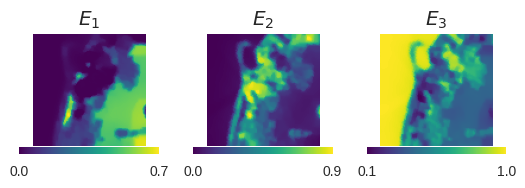

In [21]:
from utils import show_abundance
A = ELMM['A_NFINDR'].T.reshape(dataset.n_row, dataset.n_col, -1,order='C')
fig = show_abundance(np.abs(A[:, :, nfindr_idx]))
plt.show(fig)
fig.savefig(os.path.join(save_dir, 'A_NFINDR.png'), dpi=300, bbox_inches='tight')

A = ELMM['A_VCA'].T.reshape(dataset.n_row, dataset.n_col,-1,order='C')
fig = show_abundance(np.abs(A[:, :, vca_idx]))
plt.show(fig)
fig.savefig(os.path.join(save_dir, 'A_VCA.png'), dpi=300, bbox_inches='tight')

# Save Dataframe

In [10]:
df = pd.concat([lmm_df, elmm_df])
df.to_csv(os.path.join(result_path, 'metrics.csv'), index=False)
df

,Method,RMSE_X,RMSE_A,SAD_M
0,LMM+NFINDR,0.12520695,0.3332879052864812,0.223180
1,LMM+VCA,0.08434702,0.3308517982300189,0.183502
